The German credit dataset is a standard imbalanced classification dataset that has this property of differing costs to misclassification errors. Models evaluated on this dataset can be evaluated using the Fbeta-Measure that provides a way of both quantifying model performance generally, and captures the requirement that one type of misclassification error is more costly than another.

The dataset was used as part of the Statlog project, a European-based initiative in the 1990s to evaluate and compare a large number (at the time) of machine learning algorithms on a range of different classification tasks. The dataset is credited to Hans Hofmann.

The dataset includes 1,000 examples and 20 input variables, 7 of which are numerical (integer) and 13 are categorical.

* Status of existing checking account
* Duration in month
* Credit history
* Purpose
* Credit amount
* Savings account
* Present employment since
* Installment rate in percentage of disposable income
* Personal status and sex
* Other debtors
* Present residence since
* Property
* Age in years
* Other installment plans
* Housing
* Number of existing credits at this bank
* Job
* Number of dependents
* Telephone
* Foreign worker

Some of the categorical variables have an ordinal relationship, such as “Savings account,” although most do not.

In [11]:
import pandas as pd
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
# define the dataset location
filename = 'german.csv'
# load the csv file as a data frame
df = pd.read_csv(filename, header=None)
# summarize the shape of the dataset
print(df.shape)
# summarize the class distribution
target = df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(1000, 21)
Class=1, Count=700, Percentage=70.000%
Class=2, Count=300, Percentage=30.000%


Running the example first loads the dataset and confirms the number of rows and columns, that is 1,000 rows and 20 input variables and 1 target variable.

The class distribution is then summarized, confirming the number of good and bad customers and the percentage of cases in the minority and majority classes.

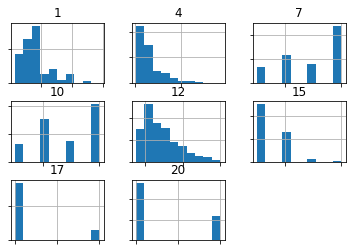

In [14]:
import matplotlib.pyplot as plt
# select columns with numerical data types
num_ix = df.select_dtypes(include=['int64', 'float64']).columns
# select a subset of the dataframe with the chosen columns
subset = df[num_ix]
# create a histogram plot of each numeric variable
ax = subset.hist()
# disable axis labels to avoid the clutter
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
# show the plot
plt.show()

We can see many different distributions, some with Gaussian-like distributions, others with seemingly exponential or discrete distributions.

Depending on the choice of modeling algorithms, we would expect scaling the distributions to the same range to be useful, and perhaps the use of some power transforms.

# Model Test and Baseline Result

We will evaluate candidate models using repeated stratified k-fold cross-validation.

The k-fold cross-validation procedure provides a good general estimate of model performance that is not too optimistically biased, at least compared to a single train-test split. We will use k=10, meaning each fold will contain about 1000/10 or 100 examples.

Stratified means that each fold will contain the same mixture of examples by class, that is about 70 percent to 30 percent good to bad customers. Repeated means that the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model. We will use three repeats.

This means a single model will be fit and evaluated 10 * 3 or 30 times and the mean and standard deviation of these runs will be reported.

This can be achieved using the RepeatedStratifiedKFold scikit-learn class.

This can be achieved by using a version of the F-measure that calculates a weighted harmonic mean of precision and recall but favors higher recall scores over precision scores. This is called the Fbeta-measure, a generalization of F-measure, where “beta” is a parameter that defines the weighting of the two scores.

Fbeta-Measure = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
A beta value of 2 will weight more attention on recall than precision and is referred to as the F2-measure.

F2-Measure = ((1 + 2^2) * Precision * Recall) / (2^2 * Precision + Recall)
We will use this measure to evaluate models on the German credit dataset. This can be achieved using the fbeta_score() scikit-learn function.

We can define a function to load the dataset and split the columns into input and output variables. We will one-hot encode the categorical variables and label encode the target variable. You might recall that a one-hot encoding replaces the categorical variable with one new column for each value of the variable and marks values with a 1 in the column for that value.

First, we must split the DataFrame into input and output variables.

The load_dataset() function below ties all of this together and loads and prepares the dataset for modeling.

In [15]:
# load the dataset
def load_dataset(full_path):
    # load the dataset as a numpy array
    dataframe = read_csv(full_path, header=None)
    # split into inputs and outputs
    last_ix = len(dataframe.columns) - 1
    X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
    # select categorical features
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    # one hot encode cat features only
    ct = ColumnTransformer([('o',OneHotEncoder(),cat_ix)], remainder='passthrough')
    X = ct.fit_transform(X)
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X, y

Next, we need a function that will evaluate a set of predictions using the fbeta_score() function with beta set to 2.

In [16]:
def f2(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

In [17]:
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(f2)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [18]:
# define the location of the dataset
full_path = 'german.csv'
# load the dataset
X, y = load_dataset(full_path)
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean F2: %.3f (%.3f)' % (mean(scores), std(scores)))

(1000, 61) (1000,) Counter({0: 700, 1: 300})
Mean F2: 0.682 (0.000)


In this case, we can see that the baseline algorithm achieves an F2-Measure of about 0.682. This score provides a lower limit on model skill; any model that achieves an average F2-Measure above about 0.682 has skill, whereas models that achieve a score below this value do not have skill on this dataset.

# Evaluate Models

>LR 0.487 (0.103)
>LDA 0.505 (0.093)
>NB 0.632 (0.062)
>GPC 0.219 (0.081)
>SVM 0.436 (0.103)


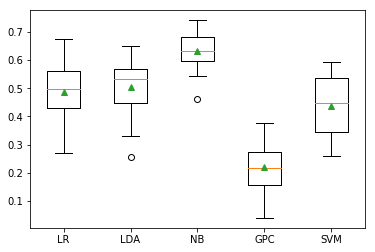

In [19]:
from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
 
# load the dataset
def load_dataset(full_path):
    # load the dataset as a numpy array
    dataframe = read_csv(full_path, header=None)
    # split into inputs and outputs
    last_ix = len(dataframe.columns) - 1
    X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
    # select categorical and numerical features
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    num_ix = X.select_dtypes(include=['int64', 'float64']).columns
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X.values, y, cat_ix, num_ix
 
# calculate f2-measure
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)
 
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(f2_measure)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores
 
# define models to test
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    # GPC
    models.append(GaussianProcessClassifier())
    names.append('GPC')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names
 
# define the location of the dataset
full_path = 'german.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # one hot encode categorical, normalize numerical
    ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
    # wrap the model i a pipeline
    pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In this case, we can see that none of the tested models have an F2-measure above the default of predicting the majority class in all cases (0.682). None of the models are skillful. This is surprising, although suggests that perhaps the decision boundary between the two classes is noisy.

Now that we have some results, let’s see if we can improve them with some undersampling.

# Evaluate Undersampling

Undersampling is perhaps the least widely used technique when addressing an imbalanced classification task as most of the focus is put on oversampling the majority class with SMOTE.

Undersampling can help to remove examples from the majority class along the decision boundary that make the problem challenging for classification algorithms.

In this experiment we will test the following undersampling algorithms:

* Tomek Links (TL)
* Edited Nearest Neighbors (ENN)
* Repeated Edited Nearest Neighbors (RENN)
* One Sided Selection (OSS)
* Neighborhood Cleaning Rule (NCR)

The Tomek Links and ENN methods select examples from the majority class to delete, whereas OSS and NCR both select examples to keep and examples to delete. We will use the balanced version of the logistic regression algorithm to test each undersampling method, to keep things simple.

The Pipeline provided by scikit-learn does not know about undersampling algorithms. Therefore, we must use the Pipeline implementation provided by the imbalanced-learn library.

As in the previous section, the first step of the pipeline will be one hot encoding of categorical variables and normalization of numerical variables, and the final step will be fitting the model. Here, the middle step will be the undersampling technique, correctly applied within the cross-validation evaluation on the training dataset only.

### Running the example evaluates the logistic regression algorithm with five different undersampling techniques.

Your specific results will vary given the stochastic nature of the learning algorithms; consider running the example a few times.

>TL 0.670 (0.062)
>ENN 0.697 (0.052)
>RENN 0.712 (0.038)
>OSS 0.668 (0.061)
>NCR 0.682 (0.050)


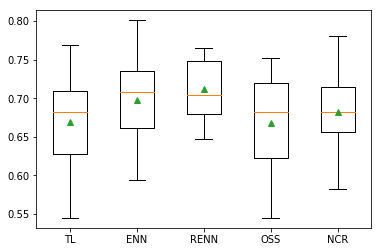

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection

# define undersampling models to test
def get_models():
	models, names = list(), list()
	# TL
	models.append(TomekLinks())
	names.append('TL')
	# ENN
	models.append(EditedNearestNeighbours())
	names.append('ENN')
	# RENN
	models.append(RepeatedEditedNearestNeighbours())
	names.append('RENN')
	# OSS
	models.append(OneSidedSelection())
	names.append('OSS')
	# NCR
	models.append(NeighbourhoodCleaningRule())
	names.append('NCR')
	return models, names
 
# define the location of the dataset
full_path = 'german.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
	# define model to evaluate
	model = LogisticRegression(solver='liblinear', class_weight='balanced')
	# one hot encode categorical, normalize numerical
	ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
	# scale, then undersample, then fit model
	pipeline = Pipeline(steps=[('t',ct), ('s', models[i]), ('m',model)])
	# evaluate the model and store results
	scores = evaluate_model(X, y, pipeline)
	results.append(scores)
	# summarize and store
	print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In this case, we can see that three of the five undersampling techniques resulted in an F2-measure that provides an improvement over the baseline of 0.682. Specifically, ENN, RENN and NCR, with repeated edited nearest neighbors resulting in the best performance with an F2-measure of about 0.716.

# Further Model Improvements

### Improvement #1: InstanceHardnessThreshold

In [27]:

from imblearn.under_sampling import EditedNearestNeighbours

In [25]:
full_path = 'german.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# define model to evaluate
model = LogisticRegression(solver='liblinear', class_weight='balanced')
# define the data sampling
sampling = InstanceHardnessThreshold()
# one hot encode categorical, normalize numerical
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
# scale, then sample, then fit model
pipeline = Pipeline(steps=[('t',ct), ('s', sampling), ('m',model)])
# evaluate the model and store results
scores = evaluate_model(X, y, pipeline)
print('%.3f (%.3f)' % (mean(scores), std(scores)))

0.722 (0.038)


### Improvement #2: SMOTEENN

An F2-measure of about 0.730 can be achieved using LDA with SMOTEENN, where the ENN parameter is set to an ENN instance with sampling_strategy set to majority.

In [28]:

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
X, y, cat_ix, num_ix = load_dataset(full_path)
# define model to evaluate
model = LinearDiscriminantAnalysis()
# define the data sampling
sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
# one hot encode categorical, normalize numerical
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
# scale, then sample, then fit model
pipeline = Pipeline(steps=[('t',ct), ('s', sampling), ('m',model)])
# evaluate the model and store results
scores = evaluate_model(X, y, pipeline)
print('%.3f (%.3f)' % (mean(scores), std(scores)))

0.727 (0.030)


## Improvement #3: SMOTEENN with StandardScaler and RidgeClassifier

In [29]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

X, y, cat_ix, num_ix = load_dataset(full_path)
# define model to evaluate
model = RidgeClassifier()
# define the data sampling
sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
# one hot encode categorical, normalize numerical
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',StandardScaler(),num_ix)])
# scale, then sample, then fit model
pipeline = Pipeline(steps=[('t',ct), ('s', sampling), ('m',model)])
# evaluate the model and store results
scores = evaluate_model(X, y, pipeline)
print('%.3f (%.3f)' % (mean(scores), std(scores)))

0.729 (0.035)


# Make Prediction on New Data

Given the variance in results, a selection of any of the undersampling methods is probably sufficient. In this case, we will select logistic regression with Repeated ENN.

This model had an F2-measure of about about 0.716 on our test harness.

We will use this as our final model and use it to make predictions on new data.

First, we can define the model as a pipeline.

First, we can define the model as a pipeline.

Once defined, we can fit it on the entire training dataset.

Once fit, we can use it to make predictions for new data by calling the predict() function. This will return the class label of 0 for “good customer”, or 1 for “bad customer”.

Importantly, we must use the ColumnTransformer that was fit on the training dataset in the Pipeline to correctly prepare new data using the same transforms.

In [30]:
# define the location of the dataset
full_path = 'german.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# define model to evaluate
model = LogisticRegression(solver='liblinear', class_weight='balanced')
# one hot encode categorical, normalize numerical
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
# scale, then undersample, then fit model
pipeline = Pipeline(steps=[('t',ct), ('s', RepeatedEditedNearestNeighbours()), ('m',model)])
# fit the model
pipeline.fit(X, y)
# evaluate on some good customers cases (known class 0)
print('Good Customers:')
data = [['A11', 6, 'A34', 'A43', 1169, 'A65', 'A75', 4, 'A93', 'A101', 4, 'A121', 67, 'A143', 'A152', 2, 'A173', 1, 'A192', 'A201'],
    ['A14', 12, 'A34', 'A46', 2096, 'A61', 'A74', 2, 'A93', 'A101', 3, 'A121', 49, 'A143', 'A152', 1, 'A172', 2, 'A191', 'A201'],
    ['A11', 42, 'A32', 'A42', 7882, 'A61', 'A74', 2, 'A93', 'A103', 4, 'A122', 45, 'A143', 'A153', 1, 'A173', 2, 'A191', 'A201']]
for row in data:
    # make prediction
    yhat = pipeline.predict([row])
    # get the label
    label = yhat[0]
    # summarize
    print('>Predicted=%d (expected 0)' % (label))
# evaluate on some bad customers (known class 1)
print('Bad Customers:')
data = [['A13', 18, 'A32', 'A43', 2100, 'A61', 'A73', 4, 'A93', 'A102', 2, 'A121', 37, 'A142', 'A152', 1, 'A173', 1, 'A191', 'A201'],
    ['A11', 24, 'A33', 'A40', 4870, 'A61', 'A73', 3, 'A93', 'A101', 4, 'A124', 53, 'A143', 'A153', 2, 'A173', 2, 'A191', 'A201'],
    ['A11', 24, 'A32', 'A43', 1282, 'A62', 'A73', 4, 'A92', 'A101', 2, 'A123', 32, 'A143', 'A152', 1, 'A172', 1, 'A191', 'A201']]
for row in data:
    # make prediction
    yhat = pipeline.predict([row])
    # get the label
    label = yhat[0]
    # summarize
    print('>Predicted=%d (expected 1)' % (label))

Good Customers:
>Predicted=0 (expected 0)
>Predicted=0 (expected 0)
>Predicted=1 (expected 0)
Bad Customers:
>Predicted=1 (expected 1)
>Predicted=1 (expected 1)
>Predicted=1 (expected 1)
